<a href="https://colab.research.google.com/github/robpalinic/Springboard-Capstone-Three/blob/main/Capstone_3_Senate_Voting_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **US Senate Voting Clusters**

## **1. Data Acquisition**

All data was scraped from the US Senate website, https://www.senate.gov/legislative/LIS/roll_call_votes/vote1171/vote_117_1_00001.xml using BeautifulSoup.  I initially scraped the HTML version of the site, but had two major problems.  First, some extraneous data was entered which needed to be cleaned.  Secondly, the scrape was unreliable, and would not always work.  The XML site was both more reliable and provided cleaner data.

In [ ]:
import requests
import time
from bs4 import BeautifulSoup
import lxml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
def scrape_senate(congress, vote):
  
  if vote<10:
    add = '000'
  elif vote<100:
    add = '00'
  else:
    add = '0' 

  URL = 'https://www.senate.gov/legislative/LIS/roll_call_votes/vote' + str(congress) + '1/vote_' + str(congress) + '_1_0' + str(add) + str(vote) + '.xml'

  page = requests.get(URL)
  soup = BeautifulSoup(page.content, "xml")
  members = soup.find_all('member')
  senators = {}
  for member in members:
    last = member.find('member_full')
    last_name = last.get_text()
    vote = member.find('vote_cast')
    vote_result = vote.get_text()
    senators[last_name] = vote_result
  return senators


In [ ]:
votes = {}
for vote in range(1,266):
  congress = 117
  results = scrape_senate(congress, vote)
  votes[vote] = results
voting = pd.DataFrame(votes)

In [ ]:
voting

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
Baldwin (D-WI),Nay,Nay,Yea,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Nay,Nay,Yea,Nay,Yea,Yea,Nay,Nay,Nay,Yea,Yea,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Nay,...,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea
Barrasso (R-WY),Nay,Nay,Yea,Nay,Yea,Nay,Nay,Nay,Yea,Nay,Yea,Nay,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,...,Nay,Nay,Yea,Nay,Yea,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Yea,Yea,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Yea,Nay,Yea
Bennet (D-CO),Nay,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Nay,Nay,Yea,Nay,Yea,Yea,Nay,Nay,Nay,Yea,Yea,Yea,Nay,Yea,Nay,Nay,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Nay,...,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea
Blackburn (R-TN),Nay,Nay,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,...,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Yea,Yea,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay
Blumenthal (D-CT),Nay,Nay,Yea,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Nay,Nay,Yea,Nay,Yea,Yea,Nay,Nay,Nay,Yea,Yea,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Nay,...,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wyden (D-OR),Nay,Nay,Yea,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Nay,Nay,Yea,Nay,Yea,Yea,Nay,Nay,Nay,Yea,Yea,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Nay,...,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea
Young (R-IN),Nay,Nay,Yea,Nay,Yea,Yea,Yea,Nay,Yea,Nay,Yea,Nay,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,...,Yea,Nay,Yea,Nay,Yea,Nay,Yea,Yea,Nay,Nay,Nay,Yea,Yea,Yea,Yea,Yea,Not Voting,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Nay,Yea,Nay,Yea,Not Voting,Not Voting,Not Voting,Not Voting,Nay,Nay,Nay,Nay,Yea,Yea,Yea,Yea
Ossoff (D-GA),NaN,NaN,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Nay,Nay,Yea,Nay,Yea,Yea,Nay,Nay,Nay,Yea,Yea,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Nay,...,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea
Padilla (D-CA),NaN,NaN,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Nay,Nay,Yea,Nay,Yea,Yea,Nay,Nay,Nay,Yea,Yea,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Yea,Nay,Nay,Nay,Nay,Nay,...,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Nay,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea,Yea




---


## **2. Data Cleansing**

### **2.1 Removing bad data and ex-senators**

In [ ]:
voting.shape

(102, 265)

There should only be 100 senators, so something is off.  The number of votes is correct.

Three records with bad data at the end, revolving around 'Guilty', 'Not Guilty' and 'Present.  These will be removed. Also, some research indicated two senate seats changed hands.  Kamala Harris's seat was replaced with Alex Padilla, while Kelly Loeffler was replaced with Raphael Warnock.  The number of senators should be 102.  Since both of these replacements happened in January, I will removed Kamala Harris and Kelly Leoffler as they had too few votes for analysis.

In [ ]:
list(voting.index)

['Baldwin (D-WI)',
 'Barrasso (R-WY)',
 'Bennet (D-CO)',
 'Blackburn (R-TN)',
 'Blumenthal (D-CT)',
 'Blunt (R-MO)',
 'Booker (D-NJ)',
 'Boozman (R-AR)',
 'Braun (R-IN)',
 'Brown (D-OH)',
 'Burr (R-NC)',
 'Cantwell (D-WA)',
 'Capito (R-WV)',
 'Cardin (D-MD)',
 'Carper (D-DE)',
 'Casey (D-PA)',
 'Cassidy (R-LA)',
 'Collins (R-ME)',
 'Coons (D-DE)',
 'Cornyn (R-TX)',
 'Cortez Masto (D-NV)',
 'Cotton (R-AR)',
 'Cramer (R-ND)',
 'Crapo (R-ID)',
 'Cruz (R-TX)',
 'Daines (R-MT)',
 'Duckworth (D-IL)',
 'Durbin (D-IL)',
 'Ernst (R-IA)',
 'Feinstein (D-CA)',
 'Fischer (R-NE)',
 'Gillibrand (D-NY)',
 'Graham (R-SC)',
 'Grassley (R-IA)',
 'Hagerty (R-TN)',
 'Harris (D-CA)',
 'Hassan (D-NH)',
 'Hawley (R-MO)',
 'Heinrich (D-NM)',
 'Hickenlooper (D-CO)',
 'Hirono (D-HI)',
 'Hoeven (R-ND)',
 'Hyde-Smith (R-MS)',
 'Inhofe (R-OK)',
 'Johnson (R-WI)',
 'Kaine (D-VA)',
 'Kelly (D-AZ)',
 'Kennedy (R-LA)',
 'King (I-ME)',
 'Klobuchar (D-MN)',
 'Lankford (R-OK)',
 'Leahy (D-VT)',
 'Lee (R-UT)',
 'Loeffler 

In [ ]:
dropped_senators = ['Harris (D-CA)', 'Loeffler (R-GA)']
voting.drop(dropped_senators, inplace=True, axis=0)

In [ ]:
voting.shape

(100, 265)

In [ ]:
voting.describe().T

,count,unique,top,freq
1,97,2,Nay,91
2,97,2,Nay,90
3,100,3,Yea,84
4,100,3,Yea,69
5,100,3,Yea,93
...,...,...,...,...
261,100,3,Yea,53
262,100,3,Yea,72
263,100,3,Yea,90
264,100,3,Yea,72


The unique column is most interesting.  There are five responses possible:  *Yea*, *Nay*, *Not Voting*, *Guilty* and *Not Guilty*.  The missing values represent senators missing a vote.  PCA can not have missing values, so I will replace those with zeros.

Also, the first two votes have counts of 97, not 100.  This is is due to two senators being replaced. 

### **2.2 Dealing with Missing Values**

In [ ]:
voting.isna().sum()

1      3
2      3
3      0
4      0
5      0
      ..
261    0
262    0
263    0
264    0
265    0
Length: 265, dtype: int64

In [ ]:
voting = voting.fillna(0)

In [ ]:
voting.isna().sum()

1      0
2      0
3      0
4      0
5      0
      ..
261    0
262    0
263    0
264    0
265    0
Length: 265, dtype: int64

### **2.3  Transforming each vote to a binary value**
For ease of modeling, 'Yea' and 'Guilty' will be changed to a 1, while all other values will be changed to 0

In [ ]:
yes = ['Yea', 'Guilty']
no = ['Nay', 'Not Guilty', 'Not Voting', 'Present']
voting.replace(yes, 1, inplace=True)
voting.replace(no, 0, inplace=True)
voting.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
Baldwin (D-WI),0,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Barrasso (R-WY),0,0,1,0,1,0,0,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,...,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
Bennet (D-CO),0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Blackburn (R-TN),0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Blumenthal (D-CT),0,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
voting.shape

(100, 265)



---


## **3. Exploratory Data Analysis**

### **3.1 Investigate Voting Congruence Between Individual Senators**

In [ ]:
#Create a function to allow comparison of voting between two senators

def two_senator_comparison(senator_a, senator_b):
  a = voting.loc[senator_a]
  b = voting.loc[senator_b]

  confusion_matrix = pd.crosstab(a, b)

  sns.heatmap(confusion_matrix,  fmt='g', cmap='crest', annot=True, cbar=False)
  plt.ylim(0,2)
  plt.xlim(2,0)
  plt.show()

**3.1.1 Comparison of Bernie Sanders and Ted Cruz**

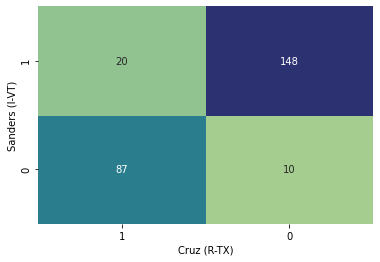

In [ ]:
two_senator_comparison('Sanders (I-VT)','Cruz (R-TX)')

Out of 265 votes, they agreed 30 times.  It is safe to say that they do not agree on much.

**3.1.2 Comparison of Bernie Sanders and Elizabeth Warren**

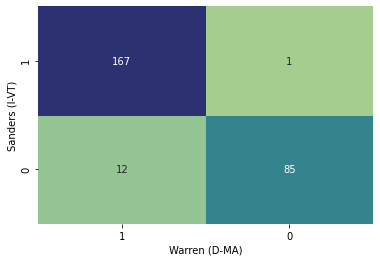

In [ ]:
two_senator_comparison('Sanders (I-VT)','Warren (D-MA)')

Bernie Sanders and Elizabeth Warren agreed on 252 out of 265 votes.  It is safe to say that they are fairly aligned.

**3.1.3 Comparison of Mitt Romney and Ted Cruz**

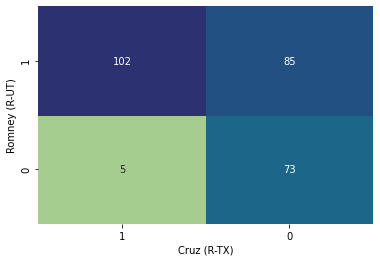

In [ ]:
two_senator_comparison('Romney (R-UT)','Cruz (R-TX)')

Agreement on 175 out of 265 votes.  For two senators in the same party, there appears to be significant disagreement.

**3.1.4 Comparison of John Cornyn and Ted Cruz, both Texas senators**

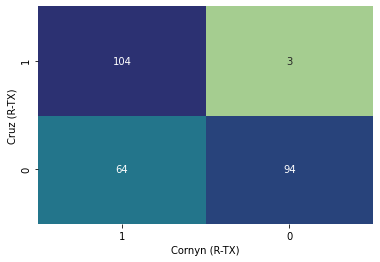

In [ ]:
two_senator_comparison('Cruz (R-TX)','Cornyn (R-TX)')

Agreement on 198 out of 265.  Closer than agreement beween Mitt Romney and Ted Cruz, but not approaching the level of Bernie Sanders and Elizabeth Warren.

**3.2 Yea votes by Vote**

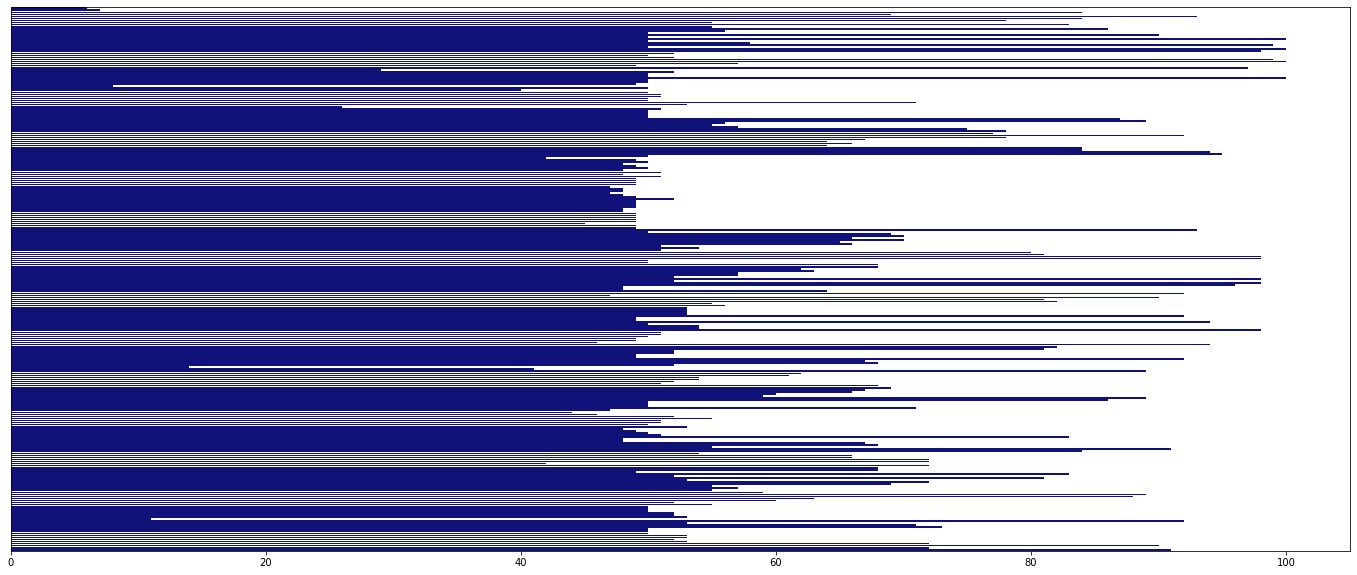

In [ ]:
#Looking at all the Senate votes, with 'Yays' in blue.
votes = voting.sum(axis=0)
plt.figure(figsize=(24, 10))
ax = sns.barplot(x=votes, y=votes.index, orient='h', color='darkblue')
ax.set(yticks=[])
plt.show()

Not surprisingly, much of the voting is split, but there appear to be many votes that deviate significantly from party voting.

**3.3  Histogram of Yay Votes**

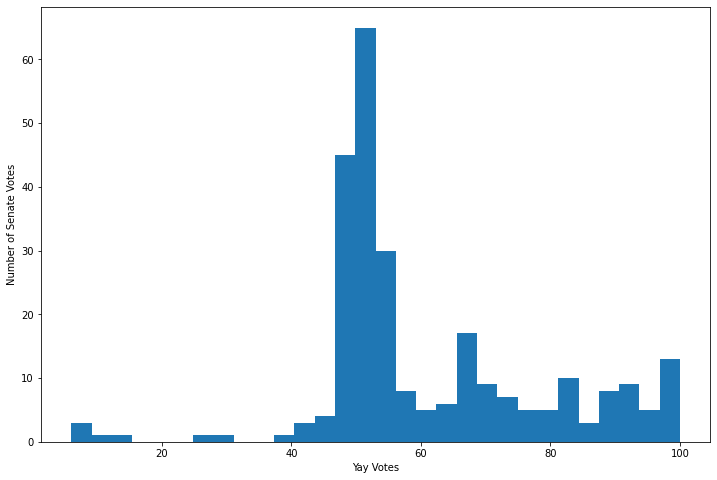

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(votes, bins=30)
plt.xlabel('Yay Votes')
plt.ylabel('Number of Senate Votes')
#plt.xticks([])
plt.show()

The histogram of 'Yay' votes reveals some interesting groupings.  First, the most common votes are around the 50 mark, indicating support from one or other (but not both) parties.  This can be viewed as partisan votes.  Secondly, there exists to the left several votes with very few 'Yays', indicating votes without party support.  It will be interesting to see who voted 'Yay' in these sessions.  Finally, to the right, there are a significant number of votes with cross party support.

**3.4  Number of Republics, Democrats and Indepenents**

In [ ]:
voting.index

Index(['Baldwin (D-WI)', 'Barrasso (R-WY)', 'Bennet (D-CO)',
       'Blackburn (R-TN)', 'Blumenthal (D-CT)', 'Blunt (R-MO)',
       'Booker (D-NJ)', 'Boozman (R-AR)', 'Braun (R-IN)', 'Brown (D-OH)',
       'Burr (R-NC)', 'Cantwell (D-WA)', 'Capito (R-WV)', 'Cardin (D-MD)',
       'Carper (D-DE)', 'Casey (D-PA)', 'Cassidy (R-LA)', 'Collins (R-ME)',
       'Coons (D-DE)', 'Cornyn (R-TX)', 'Cortez Masto (D-NV)', 'Cotton (R-AR)',
       'Cramer (R-ND)', 'Crapo (R-ID)', 'Cruz (R-TX)', 'Daines (R-MT)',
       'Duckworth (D-IL)', 'Durbin (D-IL)', 'Ernst (R-IA)', 'Feinstein (D-CA)',
       'Fischer (R-NE)', 'Gillibrand (D-NY)', 'Graham (R-SC)',
       'Grassley (R-IA)', 'Hagerty (R-TN)', 'Hassan (D-NH)', 'Hawley (R-MO)',
       'Heinrich (D-NM)', 'Hickenlooper (D-CO)', 'Hirono (D-HI)',
       'Hoeven (R-ND)', 'Hyde-Smith (R-MS)', 'Inhofe (R-OK)', 'Johnson (R-WI)',
       'Kaine (D-VA)', 'Kelly (D-AZ)', 'Kennedy (R-LA)', 'King (I-ME)',
       'Klobuchar (D-MN)', 'Lankford (R-OK)', 'Leahy (D-VT)

In [ ]:
party = {'Democrats':0,
         'Republicans':0, 
         'Independents':0}

for senator in list(voting.index):
  if '(D' in senator:
    party['Democrats'] = party['Democrats'] + 1
  elif'(R' in senator:
    party['Republicans'] = party['Republicans'] + 1
  else:
    party['Independents'] = party['Independents'] + 1

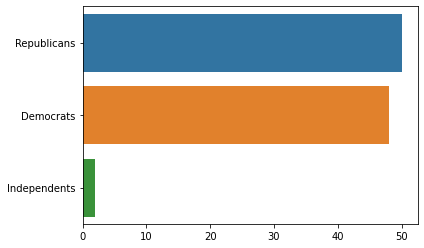

In [ ]:
keys = list(party.keys())
vals = [party[k] for k in keys]
sns.barplot(y=keys, x=vals, orient='h', order=['Republicans', 'Democrats', 'Independents'])
plt.show()

**3.5  Yay Votes by Senator**

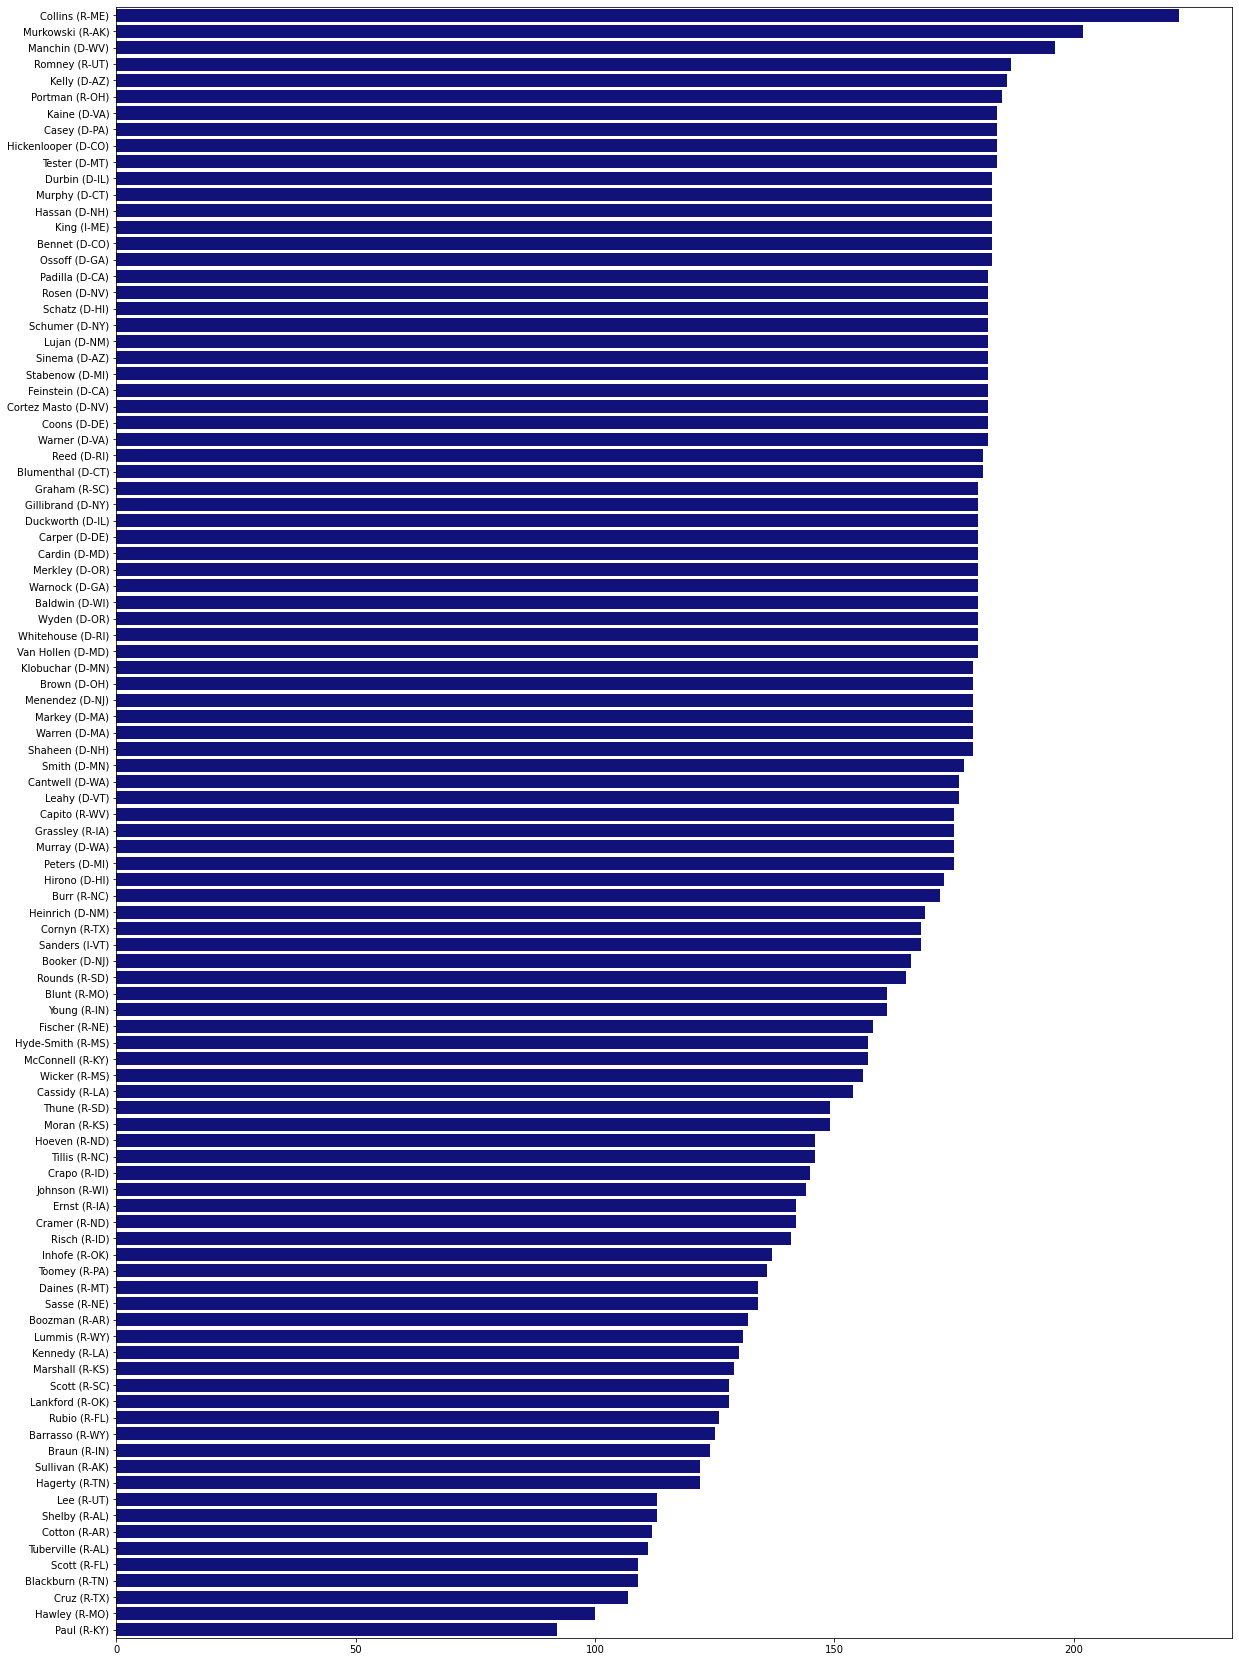

In [ ]:
sen_voting = voting.sum(axis=1)
sen_voting.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(20,30))
sns.barplot(x=sen_voting, y=sen_voting.index, orient='h', color='darkblue')
plt.show()

This is interesting, more from the Republican side than the Democrat.  Collins, Murkowsky and Romney all lead the way in 'Yea' votes, while the least number of 'Yea' votes also came from Republicans, namely Paul, Hawley and Cruz.  It would appear that there may be a split within the Republican party. Booker from New Jersey is the least 'Democratic' Democrat in terms of having the lowest number of 'Yea' votes, but he does not have an extreme position. Right next to him?  Bernie Sanders.

## **4. Modeling**

### **4.1 Principal Component Analysis (PCA)**

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(voting)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'], 
                           index=voting.index)

print(pca.explained_variance_ratio_)

[0.75471559 0.04811854]


The explained variance for the two components is 0.755 and 0.048, for a total of 0.8.  Principal component 1 is accounts for most of the difference between the groups, and is shown in the graph below as the divisor between Democrats on the left and Republicans on the right.

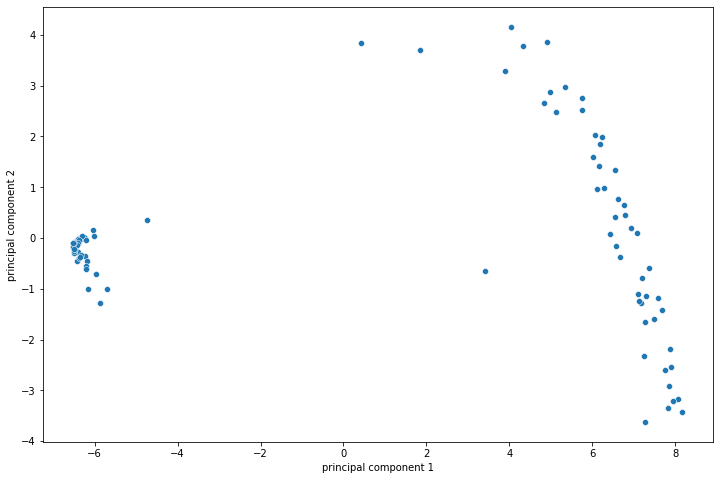

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='principal component 1', y='principal component 2', data=principalDf)
plt.show()

Clearly there are some groupings involved.  On the left is the Democratic Party senators, who show very little variability amongst themselves.  On the other hand, there is wide variability among the Republican Senators, with one seemingly cast adrift in the middle.

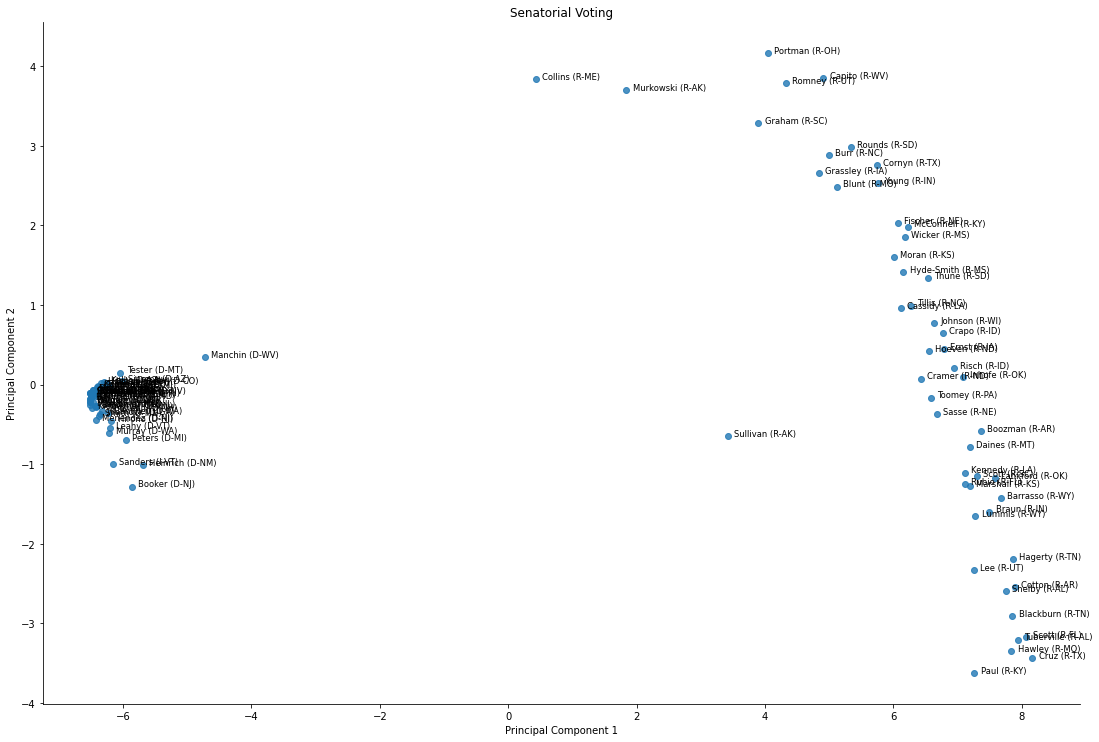

In [ ]:
#Same graph, but with Senator names attached

ax = sns.lmplot(x='principal component 1', 
           y='principal component 2', 
           data=principalDf,
           fit_reg=False, 
           height = 10,
           aspect = 1.5) 

plt.title('Senatorial Voting')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

principalDf['Senator'] = principalDf.index
pc1 = principalDf['principal component 1']
pc2 = principalDf['principal component 2']
names = principalDf['Senator']

#Adds Senator names to scatter plot.
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.1, point['y'], str(point['val']), fontsize='small' )

label_point(pc1, pc2, names, plt.gca()) 

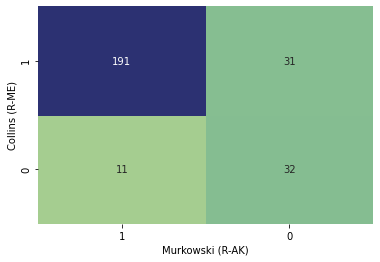

In [ ]:
two_senator_comparison('Collins (R-ME)','Murkowski (R-AK)')

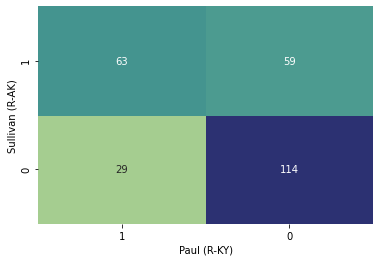

In [ ]:
two_senator_comparison('Sullivan (R-AK)','Paul (R-KY)')

### **4.2 KMeans Clustering**

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(voting)
voting_prep = voting.index
labs = kmeans.labels_
#voting_prep
principalDf['Label'] = list(kmeans.labels_)

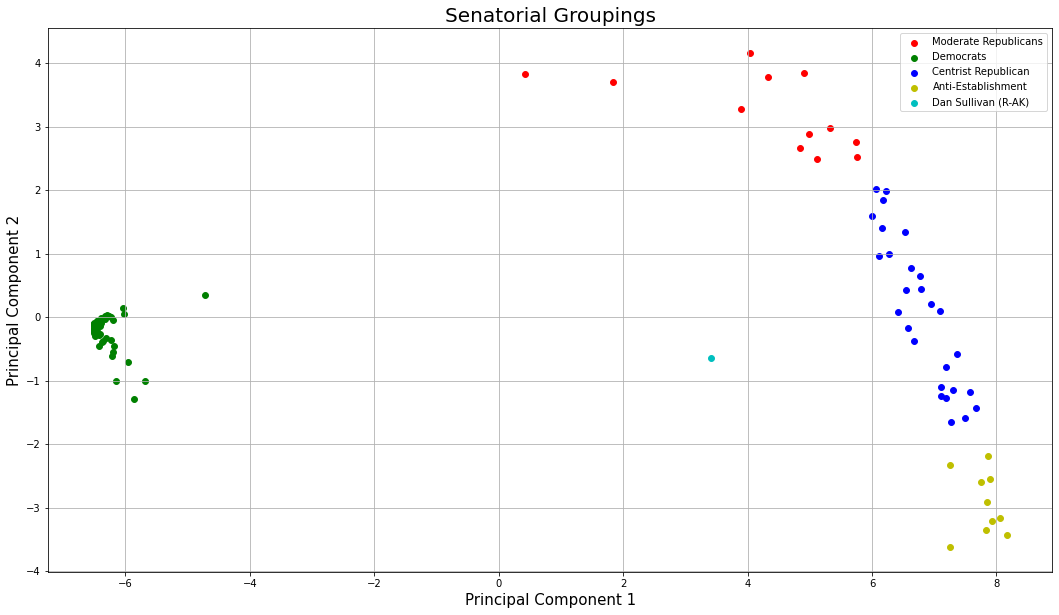

In [ ]:
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Senatorial Groupings', fontsize = 20)

targets = [0,1,2,3,4]
target_labels = ['Moderate Republicans', 'Democrats', 'Centrist Republican', 'Anti-Establishment', 'Dan Sullivan (R-AK)']
colors = ['r', 'g', 'b', 'y', 'c', 'm']

for target, color in zip(targets,colors):
    indicesToKeep = principalDf['Label'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 35)
ax.legend(target_labels)
ax.grid()

I have chosen five clusters as being most representative of the findings.  The Democrats are their own cluster with little variance.  Dan Sullivan of Alaska is his own cluster in the middle, and the rest of the Republican party can be split into Moderates, Centrists and Anti-Establishment.

Read this article to learn more about some of the moderate Republicans.  This clustering has apparently been very accurate in identifying the group.  https://thehill.com/homenews/senate/547063-moderate-gop-senators-and-biden-clash-at-start-of-infrastructure-debate